# Pipelines in Scikit-Learn

Pipelines encapsualted in `sklearn.pipeline.Pipeline` allow us to sequentially apply a list of trasformations, followed by a final estimator on our data. Each intermediate steps implements a fit and transform method, while the final estimator has a fit method. This allows us to chain fitting of all transformations using a single fitting on the dataset. 

```{figure} ../img/pipelines.png
---
width: 45em
name: pipelines
---
Pipelines allow us to cleanly separate declarative from imperative code. [[source]](https://gh.mltrainings.ru/presentations/LopuhinJankiewicz_KaggleMercari.pdf)
```


According to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), the purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. However, as shown in the above figure, pipelines also allow us to organize our code, making it easier to write and debug code. We will try to demonstrate this using the Median House Price Prediction dataset following Chapter 2 of {cite}`geron2019hands-on`. 


## California Median House Price Dataset

```{margin}
**House price prediction**
```

The task is to use California census data to build a model of housing prices in the state for a real estate investing company. This data includes
metrics such as the population, median income, and median housing price for each district [^ref1] in California. Our model should learn from this data and be able to predict the **median housing price** in any district. We will use MAPE as our evaluation metric.

[^ref1]: A district or block group is the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

### Getting the Data

We download the data using the `request.urlretrieve` function from `urllib`. This function takes a URL where the data is hosted and a save path where the data will be stored on the local disk.

In [3]:
import pandas as pd
import numpy as np
import warnings
import os
from pathlib import Path
import tarfile
import urllib.request

warnings.filterwarnings("ignore")
%matplotlib inline


def fetch_housing_data(housing_url, housing_path):
    '''Download data from `housing_url` and save it to `housing_path`.'''
    
    # Make directory
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    
    # Download data in housing_url to tgz_path
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    # Extract tar file
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Downloading...

In [4]:
# Dataset URL
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# Local save path
DATA_DIR = Path().resolve().parents[1] / 'data'
HOUSING_PATH = DATA_DIR / "housing"

# Downloading the data
fetch_housing_data(HOUSING_URL, HOUSING_PATH)

#### Quick Look at the Dataset

Let us load the data using pandas.

In [5]:
housing = pd.read_csv(HOUSING_PATH / "housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.shape

(20640, 10)

Each row represents one district which is described by 10 attributes (including the target `median_house_value`).

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


The feature `total_bedrooms` is sometimes missing. All features are numerical except `ocean_proximity` which is text.

In [8]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe() # statistics of numerical features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We can better visualize this table using histograms.

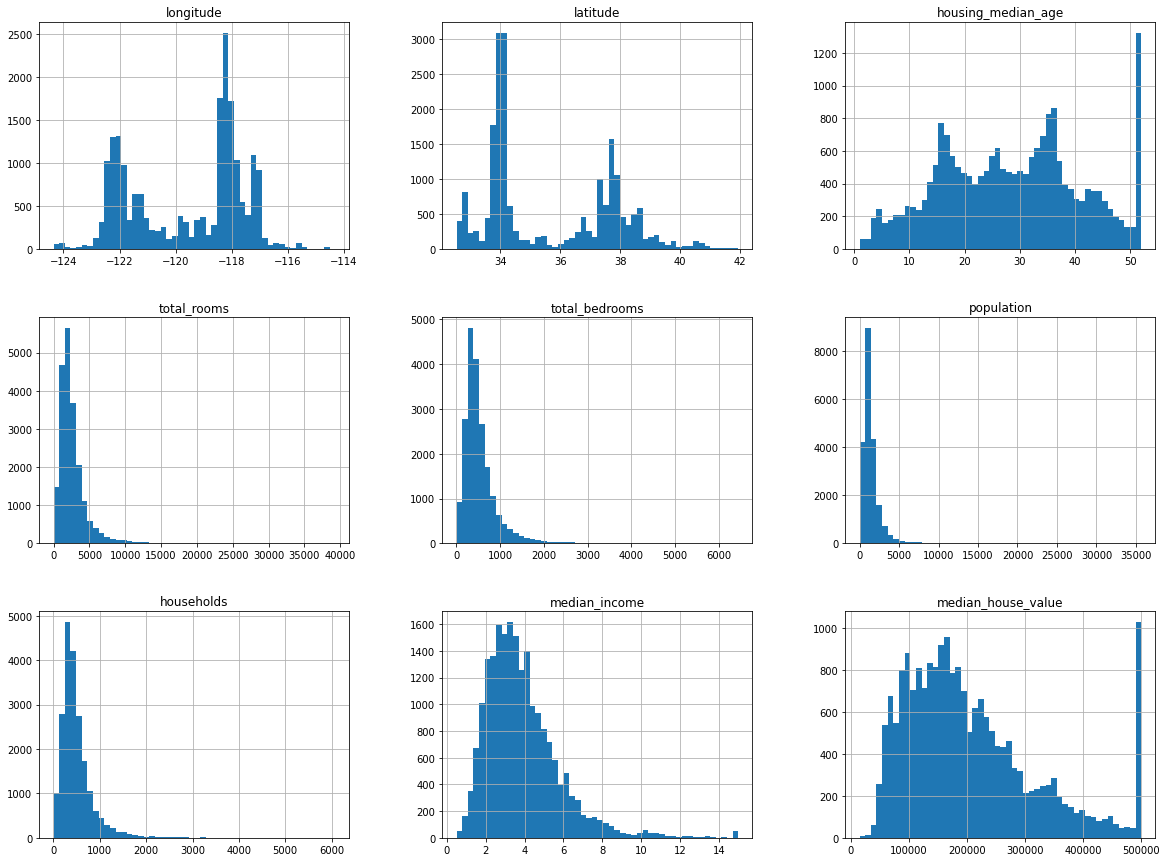

In [10]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Some observations and metadata.

* Median income are clipped between 0.5 and 15. This is measured in roughly $10,000 units. 

+++

* Housing median age and median house values are also capped. The latter may be a serious problem since it is our target, e.g. the model may learn that prices never go beyond the maximum value. Two options: (1) gather more data for districts whose labels are capped, or (2) remove these from training set (and also from the test set, since the model should not be evaluated poorly for districts outside this range).

+++

* These attributes have very different scales. Depending on the algorithm, we might need to perform feature scaling.

+++

* Many histograms are tail-heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some ML algorithms to detect patterns. We will try transforming these attributes later on to have more symmetric distributions.

#### Creating a Test Set

We can consider purely random sampling methods using `train_test_split` from `sklearn.model_selection`. This is generally fine if the dataset is large enough (especially relative to the number of attributes), but if it
is not, we run the risk of introducing a significant sampling bias.

Suppose we chatted with experts who told us that the median income is a very
important attribute to predict median housing prices. We may then perform **stratified sampling** based on income categories to ensure that the test set is representative of the various categories of incomes in the whole dataset. 

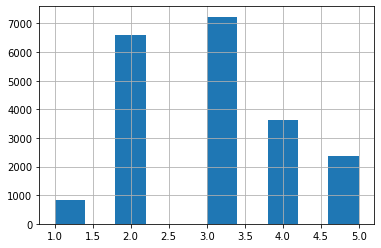

In [11]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"].hist();

In [12]:
housing["income_cat"].value_counts(normalize=True)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [13]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

We check the percentage error based on the `income_cat` distribution of the whole dataset.

In [14]:
uniform_error = (test_set['income_cat'].value_counts(normalize=True) - housing["income_cat"].value_counts(normalize=True))
uniform_error / housing["income_cat"].value_counts(normalize=True)

3    0.022664
2    0.017323
4   -0.050563
5   -0.043184
1    0.009732
Name: income_cat, dtype: float64

In [15]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, 
                                                   random_state=42, 
                                                   stratify=housing['income_cat'])
    
strat_error = strat_test_set['income_cat'].value_counts(normalize=True) - housing["income_cat"].value_counts(normalize=True)
strat_error / housing["income_cat"].value_counts(normalize=True)

3   -0.000138
2   -0.000152
4    0.000275
5   -0.000847
1    0.003650
Name: income_cat, dtype: float64

This looks way better. Dropping the temporary feature `income_cat` from the train and test sets.

In [16]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Data Visualization

Starting here, we will use `strat_train_set` as our raw train dataset and `start_test_set` as our raw test dataset.

In [17]:
housing = strat_train_set.copy()

#### Geographical Data

We plot the geospatial location of each district on a map, with color based on the median house price of each district in the dataset. Moreover, the size of the blob is proportional to its population.

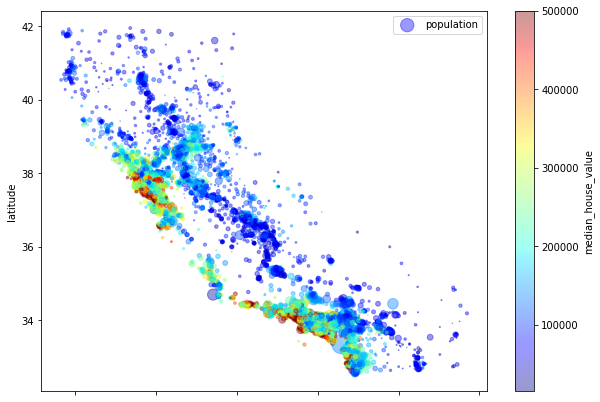

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend();

**Fig.** California housing prices: red is expensive, blue is cheap, larger circles indicate areas with a larger population

This image tells us that the housing prices are very much related to the location
(e.g., close to the ocean) and to the population density which makes sense.
A clustering algorithm should be useful for detecting the main cluster and for adding
new features that measure the proximity to the cluster centers. The ocean proximity
attribute may be useful as well, although in Northern California the housing prices in
coastal districts are not too high, so it is not a simple rule.

#### Looking for Correlations

```{caution}
This only measures **linear correlations**. It may completely miss
out on meaningful nonlinear relationships.
```

Let us look at correlations of the target with other features.

In [19]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False) 

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Looks like our experts are correct in saying that median income is predictive of median house value.

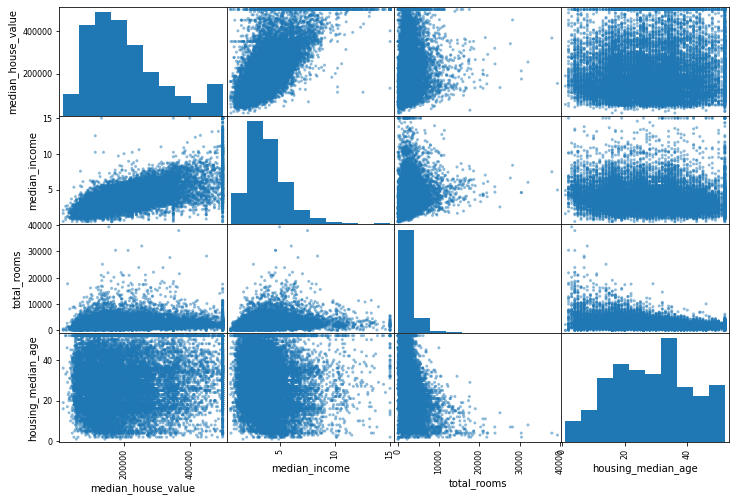

In [20]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8));

This matrix is symmetric. So we can focus our attention, on the upper half. In particular, we look at the plot `median_house_value` vs `median_income`. This reveals a few things:
* There is a clear upward trend and the values are not too dispersed. 

+++

* The plot clearly shows that the house value is clipped at around 500,000. But notice that there are horizontal lines around 350,000 and 450,000. Perhaps these are round numbers that occur across the median income range, and are determined by other features. We may want to try removing the corresponding districts to prevent our algorithms from learning to reproduce these data quirks.

#### Feature Combinations

We experiment with feature combinations. Here, we look at ratios. These are usually meaningful since they balance out scale.

In [21]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]   
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"] 
housing["population_per_household"]=housing["population"] / housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

The new `bedrooms_per_room` attribute is much more correlated with
the median house value than the total number of rooms or bedrooms. Apparently
houses with a lower bedroom/room ratio tend to be more expensive. This makes sense. The number of
rooms per household `rooms_per_household` is also more informative than the total number of rooms `total_rooms` in a
district—obviously the larger the houses, the more expensive they are.

## Preprocessing

Revert back to the original stratified train set:

In [22]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

For dealing with missing features, the three most basic methods are to:
1. Get rid of the corresponding districts (drop rows).
2. Get rid of the whole feature (drop column).
3. Imputation with some derived value (zero, mean, median, etc.).

```python
housing.dropna(subset=["total_bedrooms"])     # option 1
housing.drop("total_bedrooms", axis=1)        # option 2

median = housing["total_bedrooms"].median()   # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

We separate processing of numerical and categorical variables, then perform median imputation on numerical features.

In [23]:
from sklearn.impute import SimpleImputer

housing_num = housing[[f for f in housing.columns if f != 'ocean_proximity']]
housing_cat = housing[['ocean_proximity']]

# Fitting the imputer on numerical fetures
imputer = SimpleImputer(strategy='median')
imputer.fit(housing_num)

# Checking...
(imputer.statistics_ == housing_num.median().values).all()

True

Finally, we check that there are no more null values in the datasets

In [24]:
X = imputer.transform(housing_num)
housing_num_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

housing_num_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [25]:
housing_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ocean_proximity  16512 non-null  object
dtypes: object(1)
memory usage: 258.0+ KB


### Categorical Features

We perform **one-hot encoding** on the `ocean_proximity` feature. An alternative would be **ordinal encoding** whose order is based on the mean target value of the data conditioned on that categorical variable.

```{margin} 
Learning embeddings is
an example of **representation learning**.
```

:::{note}
If a categorical attribute has a large number of possible categories
(e.g. country code, profession, species), then one-hot encoding will
result in a large number of input features. This may slow down
training and degrade performance by increasing the dimensionality of each training instance. 

If this happens, we may want
to replace the categorical input with useful numerical features
related to the categories: for example, we could replace the
`ocean_proximity` feature with the distance to the ocean (similarly,
a country code could be replaced with the country’s population and
GDP per capita). Alternatively, we could replace each category
with a learnable, low-dimensional vector called an **embedding**. Each
category’s representation would be learned during training. 
:::

In [25]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_onehot = cat_encoder.fit_transform(housing_cat)

housing_cat_onehot # sparse

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [26]:
housing_cat_onehot.toarray() # dense

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [27]:
cat_encoder.categories_ # learned categories

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

Although scikit-learn provides many useful transformers, we will need to write own for tasks such as custom cleanup operations or combining specific
attributes. Custom transformers work seamlessly with existing scikit-learn functionalities such as `pipelines`, all we need to do is create a class and implement three methods: `fit()` that returns `self`, `transform()`, and `fit_transform()`.

We can get the last one for free by simply adding `TransformerMixin` as a base class. If we add `BaseEstimator` as a base class (and avoid `*args` and `**kwargs` in our constructor), we will also get two extra methods, `get_params()` and `set_params()`, that will be useful for automatic hyperparameter tuning.

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin

# Column indices
rooms_, bedrooms_, population_, households_ = 3, 4, 5, 6 


class CombinedFeaturesAdder(BaseEstimator, TransformerMixin):
    """Transformer for adding feature combinations discussed above."""
    
    def __init__(self, add_bedrooms_per_room=True): # No *args, **kwargs (!)
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_] / X[:, households_]
        population_per_household = X[:, population_] / X[:, households_]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_] / X[:, rooms_]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In this example the transformer has one hyperparameter, `add_bedrooms_per_room`,
set to `True` by default (it is often helpful to provide sensible defaults). This hyperparameter will allow us to easily find out whether adding this attribute helps the
ML algorithms or not. For now, we set this to `False`.

In [29]:
feature_adder = CombinedFeaturesAdder(add_bedrooms_per_room=False)
housing_extra_features = feature_adder.transform(housing.values)

Checking the shapes, the `feature_adder` should add two columns to the feature set.

In [30]:
housing.shape

(16512, 9)

In [31]:
housing_extra_features.shape

(16512, 11)

### Feature Scaling

With few exceptions, ML algorithms don’t perform well when
the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about $6$ to $39,320$, while the median incomes only range from $0$ to $15.$ There are two common ways to get all features to have the same scale: min-max scaling and standardization.

Min-max scaling results in values in the range $[0, 1]$ by subtracting with the `min` value and dividing by the total range `max - min`. Note that this scaling method is sensitive to outliers. To standardize features, first subtract the mean value (so standardized features always have a zero mean), and then divide by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization
does not bound values to a specific range, which may be a problem for some algorithms. However, standardization is much less affected by outliers. These two methods are implemented in scikit-learn as [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) and
[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) as part of the `sklearn.preprocessing` library.

### Pipelines

A nice way of coding a sequence of transformations on the data is by using sklearn's `Pipeline` object. The `Pipeline` constructor takes a list of name estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e. they must have a `fit_transform()` method). The names can be anything as long as they are unique and don't contain double underscores. Two things to note:

* Calling the pipeline's `fit()` method calls `fit_transform()` sequentially on all transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it calls the `fit()` method.

+++

* The pipeline exposes the same methods as the final estimator. In the following example, the last estimator is a `StandardScaler`, which is a transformer, so the pipeline has a `transform` method that applies all the transforms to the data in sequence. 

Observe that we define two pipelines which transforms numerical and categorical features separately. These are combined using `ColumnTransformer` into a single pipeline. Note that `ColumnTransformer` drops unprocessed columns by default. Setting `remainder='passthrough'` means that all remaining columns will be ignored and included in the final transformed data.

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


# Pipeline for numerical features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('feature_adder', CombinedFeaturesAdder()),
    ('std_scaler', StandardScaler()),    
])

# Pipeline for categorical features
cat_pipeline = Pipeline([('one_hot', OneHotEncoder())])

# Combined full preprocessing pipeline
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

# Preprocessed dataset
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

:::{note}
`OneHotEncoder` returns a sparse matrix, while the `num_pipeline` returns
a dense matrix. When there is such a mix of sparse and dense matrices, the `ColumnTransformer` estimates the density of the final matrix (i.e., the ratio of nonzero
cells), and it returns a sparse matrix if the density is lower than a given threshold (by
default, `sparse_threshold=0.3`). In this example, it returns a dense matrix.
:::

In [32]:
housing_prepared[:1]

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [33]:
full_pipeline.sparse_threshold

0.3

:::{caution}  
`ColumnTransformer` has an argument with default `remainder='drop'` which means non-specified columns in the list of transformers are dropped. Instead, we can specify `remainder='passthrough'` where all remaining columns are skipped and  concatenated with the output of the transformers.
:::

## Fine Tuning

To fine tune machine learning models, one option would be to manually test out combinations of hyperparameters. This can be very tedious, and we may not have the time or resources to explore many combinations. But it also builds intuition on what ranges work for each hyperparameter. 

After getting a rough idea of the search space, or at least its boundaries, we can start performing automated search. Here we use the two most basic: **random search** and **grid search**. Random search evaluates a fixed number of randomly chosen hyperparameter combinations. Grid search evaluates every hyperparameter combination to find the best hyperparameters. We can start with random search, then switch to grid search on a small region around the optimal point found using random search.

```{figure} ../img/grid-random-search.png
---
width: 40em
name: grid-random
---
Comparison of grid search and random search for minimizing a function with one
important and one unimportant parameter. [[source]](https://www.automl.org/wp-content/uploads/2019/05/AutoML_Book.pdf)
```

### Random Search

As discussed above, we begin with random search. The endpoints of the search space are obtained experimentally by doing several runs. Let us look at the parameters `RandomizedSearchCV` which implements random search in scikit-learn. The parameter `param_distributions` expects a dictionary which maps the name of a model hyperparameter to a range of values. If the range is a list, then the values are sampled uniformly, otherwise we can pass a probability distribution. The product of the ranges define a search space for the hyperparameter optimizer. 

In the code below, we have a grid of 80 × 30 = 2400 points. The algorithm randomly samples `n_iter` points which are scored on the held-out data, according to the `scoring` parameter. We use the MSE as scoring function which is more stable than MAPE. Since we use `n_iter=50` and `cv=5`, so we train the Random Forest model 250 times, with different train times for different hyperparameter values, e.g. increasing `max_features` generally increase train time. Note that the initialized parameters of the model will be fixed over all model evaluations on the grid.

In [35]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define search space which is a grid
param_grid = [
    {'max_features': range(2, 20), 'max_depth': range(8, 32, 2)},
]

# Initialize model parameters, and search algorithm
rf = RandomForestRegressor(random_state=42, n_estimators=200)
random_search = RandomizedSearchCV(rf, param_grid, cv=5, n_iter=50, 
                                   random_state=42,
                                   scoring='neg_mean_squared_error')

# Cross-validate on data
random_search.fit(housing_prepared, housing_labels)

# Display results
pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True).head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.575335,0.473039,0.232863,0.003401,8,28,"{'max_features': 8, 'max_depth': 28}",-2.273080e+09,-2.448910e+09,-2.548562e+09,-2.242411e+09,-2.501858e+09,-2.402964e+09,1.230748e+08,1
1,16.197997,3.641127,0.357813,0.154869,6,28,"{'max_features': 6, 'max_depth': 28}",-2.294691e+09,-2.477099e+09,-2.533561e+09,-2.248387e+09,-2.539102e+09,-2.418568e+09,1.228696e+08,2
2,13.557721,0.858428,0.201526,0.021692,8,18,"{'max_features': 8, 'max_depth': 18}",-2.269485e+09,-2.482522e+09,-2.551831e+09,-2.253163e+09,-2.542640e+09,-2.419928e+09,1.317710e+08,3
3,11.587414,0.294642,0.232247,0.026599,6,20,"{'max_features': 6, 'max_depth': 20}",-2.286340e+09,-2.499339e+09,-2.534561e+09,-2.253951e+09,-2.525913e+09,-2.420021e+09,1.233482e+08,4


The following plot shows an interesting relationship between `max_features` and `max_depth`. Looks like the points are scored with radial symmetry around the optimal point near (8, 25).

```{margin}
**Plotting** only works for pairs, or at most triples, of hyperparameters. One **greedy approach** is to fine tune two or three of most important parameters, plotting the results. Then, proceed to tune other parameters while keeping the obtained optimal values for the earlier parameters.
```

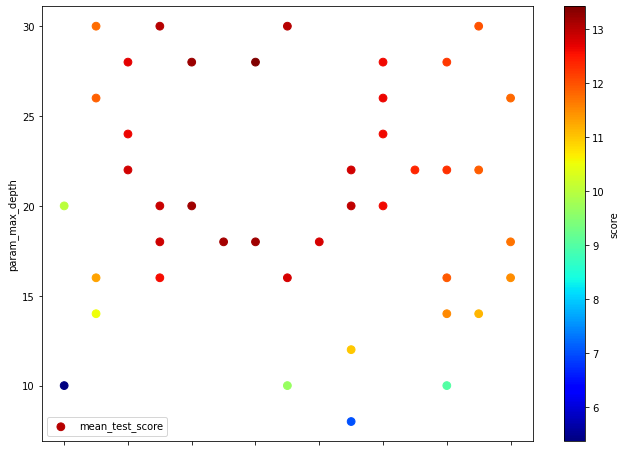

In [36]:
results = pd.DataFrame(random_search.cv_results_)
results['score'] = np.exp(5 + (results['mean_test_score'] / 1e9))

# plot
results.plot(kind='scatter', x='param_max_features', y='param_max_depth',
             c='score', s=60, cmap=plt.get_cmap("jet"), colorbar=True, 
             label="mean_test_score", figsize=(11,8));

In [37]:
random_search.best_estimator_

RandomForestRegressor(max_depth=28, max_features=8, n_estimators=200,
                      random_state=42)

### Grid Search

From the plot, it looks like the range around `15 ≤ max_depth ≤ 30` and `5 ≤ max_features ≤ 10` seem to contain good hyperparameter values. We perform a finer search by doing grid search on the grid defined by these ranges. Note that since the optimal point for the above random search is inside this grid, the cross-validated performance should only improve.

```{caution}
Make sure the search space **contains** the parameters of the best model from random search. Otherwise, grid search will not guarantee an improvement in performance.
```

In [38]:
# Search space contains `max_depth=28` and `max_features=8`
param_grid = [{'max_depth': range(15, 31), 'max_features': range( 5, 11)}]

# Improve best model from random search
rf = random_search.best_estimator_ 
grid_search = GridSearchCV(rf, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

# Cross-validate on the dataset
grid_search.fit(housing_prepared, housing_labels);

# Display results
columns = ['param_max_depth', 'param_max_features', 'rank_test_score', 'mean_test_score']
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')[columns].reset_index(drop=True).head(5)

,param_max_depth,param_max_features,rank_test_score,mean_test_score
0,28,8,1,-2.402964e+09
1,30,8,2,-2.403841e+09
2,25,8,3,-2.407862e+09
3,24,8,4,-2.408397e+09
4,24,7,5,-2.408988e+09


Turns out the mean test score of `-2.402964e+09` from random search is already the best combination for this grid.

In [39]:
best_model = grid_search.best_estimator_
print(best_model)

RandomForestRegressor(max_depth=28, max_features=8, n_estimators=200,
                      random_state=42)


:::{tip}

Instead of tuning a single model, `GridSearchCV` and `RandomSearchCV` can be used to tune *entire* prediction pipelines. The naming convention for the parameters to tune `param_grid` is a straightforward, recursive use of `__`  combining the names of the pipeline elements. This explains why we are not allowed to use double underscores and non-unique names for names of pipeline elements. 

```python
# Append estimator to preprocessing pipeline
best_model = grid_search.best_estimator_
prediction_pipeline = Pipeline([
    ("preprocessing", full_pipeline),
    ("rf", best_model)
])

# Specify search space
param_grid = [{
    'preprocessing__num__feature_adder__add_bedrooms_per_room': [True, False], 
    'rf__bootstrap': [True, False],
    }]

# Hyperparameter search
grid_search = GridSearchCV(prediction_pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error')

# Fit unprocessed data
grid_search.fit(housing, housing_labels)
grid_search.best_estimator_
```

This returns the estimator below. Observe that `add_bedrooms_per_room=False` is the better parameter setting. This example shows that even preprocessing steps can be optimized as part of scikit-learn's pipeline architecture. Neat!

```python
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('feature_adder',
                                                                   CombinedFeaturesAdder(add_bedrooms_per_room=False)),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder())]),
                                                  ['ocean_proximity'])])),
                ('rf',
                 RandomForestRegressor(bootstrap=False, max_depth=28,
                                       max_features=8, n_estimators=200,
                                       random_state=42))])

```
:::

### Feature Importance

We often gain good insights on the problem by inspecting the best models. For
example, the `RandomForestRegressor` can indicate the relative importance of each
attribute for making accurate predictions:

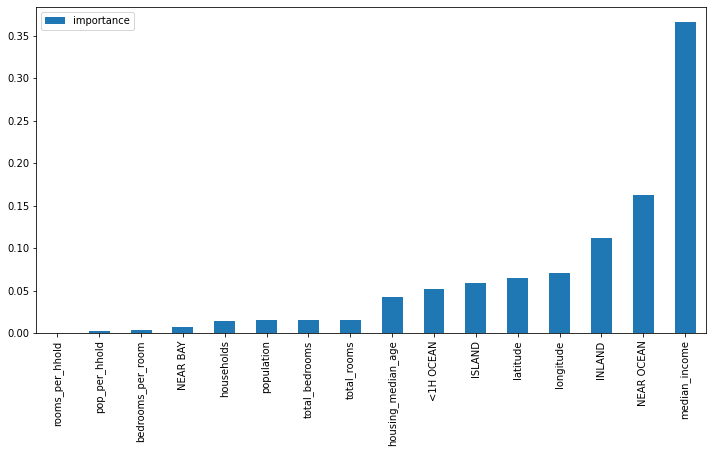

In [40]:
# Random forest feature importances
feature_importances = best_model.feature_importances_

# List of numerical and categorical features
num_features = list(housing_num)
cat_ohe_features = list(full_pipeline.named_transformers_["cat"]['one_hot'].categories_[0])

# Extra features depend on custom transformer
extra_features = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"] \
                if full_pipeline.named_transformers_['num']['feature_adder'].add_bedrooms_per_room \
                else ["rooms_per_hhold", "pop_per_hhold"]

# Combine everything to get all columns
attributes = num_features + cat_ohe_features + extra_features
feature_importance_df = pd.DataFrame(feature_importances, index=attributes, columns=['importance'])
feature_importance_df.sort_values('importance').plot.bar(figsize=(12, 6));

### Evaluating on the Test Set

Before evaluating on the test set, it is best practice to look at the specific errors that the system makes, then try to understand 
why it makes them and what could fix the problem (adding extra features or getting rid of 
uninformative ones, cleaning up outliers, etc.). For the sake of demonstration, we proceed directly to evaluation on the test set, and perform the error analysis there.

In [41]:
targets = strat_test_set['median_house_value']
preds = best_model.predict(full_pipeline.transform(strat_test_set.drop('median_house_value', axis=1)))

print('RMSE:', np.sqrt(mean_squared_error(targets, preds)))
print('MAPE:', mean_absolute_percentage_error(targets, preds))

RMSE: 46750.32067848661
MAPE: 0.17776367082261688


This is better than the human experts baseline! 

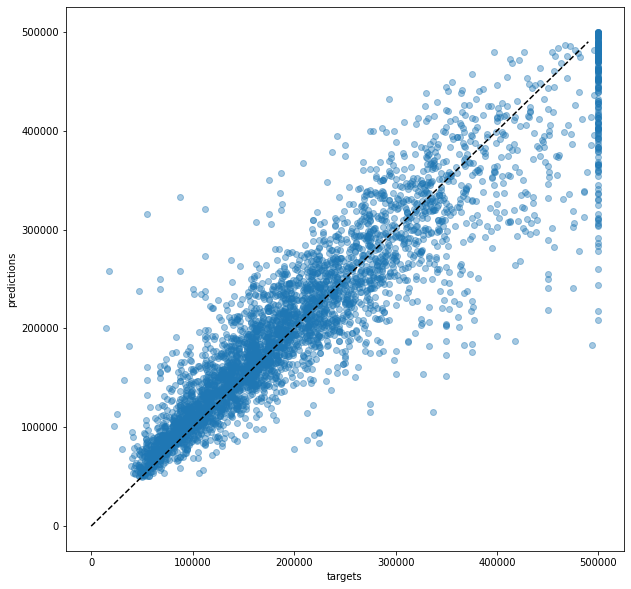

In [42]:
plt.figure(figsize=(10, 10))
plt.scatter(targets, preds, alpha=0.4);
plt.plot(range(0, 500000, 10000), range(0, 500000, 10000), 'k--')
plt.xlabel('targets')
plt.ylabel('predictions');

The model performs badly for targets at 500,000. The model predicts below this value, which is understandable from the data. From the plot, we can observe the model performs best when predicting up to 300,000. For predictions beyond 300,000 actual values are more dispersed. This might have to do with having little data in this region as the following plot shows. (See also tip in the monitoring section about having dedicated subsets for error analysis.)

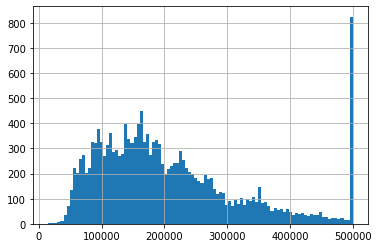

In [43]:
strat_train_set['median_house_value'].hist(bins=100);

Finally, we calculate the [95% confidence interval](https://sphweb.bumc.bu.edu/otlt/MPH-Modules/BS/BS704_Confidence_Intervals/BS704_Confidence_Intervals_print.html) for the generalization error using `scipy.stats.t.interval`.

In [44]:
from scipy import stats

confidence = 0.95
squared_errors = (preds - targets)**2
m = len(squared_errors)

# confidence interval
np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([44780.19997041, 48640.70988064])

## Conclusion

Pipelines are **awesome**. We can define custom transformers using mixins, which we can then use as part of scikit-learn pipelines, which makes this technique very flexible. For example, even preprocessing can be included in a pipeline, and therefore be part of cross-validation.